# Voronoi Generator

This project provides an interactive interface to generate Voronoi-styled images.


<img src="figures/example1.png" width="100%">


---

## Logging System


In [14]:
from ipywidgets import Output, Layout
from IPython.display import display, HTML

log_output = Output(layout=Layout(border='1px solid black', width='90%', height='150px', overflow='auto'))

def log_info(message):
    log(f"ℹ️ INFO: {message}", "#007acc")

def log_success(message):
    log(f"✅ SUCCESS: {message}", "#28a745")

def log_warning(message):
    log(f"⚠️ WARNING: {message}", "#cc9900")

def log_error(message):
    log(f"❌ ERROR: {message}", "#d9534f")

def log(message, color):
    with log_output:
        display(HTML(f"<span style='color: {color};'>{message}</span>"))


---

## Mask Management & Editing

This section provides utilities to:
- **Create and edit masks** using an external image editor.
- **List available masks** stored in the system.
- **Load masks** for Voronoi-based generation.


In [15]:
import numpy as np
import os
import subprocess
from PIL import Image

DENSITIES_DIR = "models/densities"
TEXTURES_DIR = "models/textures"
IMAGES_DIR = "models/images"

def open_paint(image_path):
    if os.name == 'nt':  # Checks if the system is Windows
        subprocess.run(["mspaint", image_path], check=True)
    else:
        log_error("Microsoft Paint is not available on this system.")

def edit_mask_in_paint(directory, name="custom", size=200):
    image_path = os.path.join(directory, f"{name}.png")
    if not os.path.exists(image_path):
        mask = np.ones((size, size), dtype=np.uint8) * 255
        Image.fromarray(mask).save(image_path)

    open_paint(image_path)

def list_mask_files(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return [os.path.splitext(f)[0] for f in os.listdir(directory) if f.endswith(".png")]

def load_mask(directory, name, mode, inverted):
    image_path = os.path.join(directory, f"{name}.png")
    if not os.path.exists(image_path):
        log_error(f"The mask '{image_path}' does not exist. Use 'create_or_edit_mask' to create it.")

    image = Image.open(image_path)

    if mode == "L":
        # Corrects the background in case of transparent pixels
        image = Image.alpha_composite(
            Image.new("RGBA", image.size, (255, 255, 255, 255)),
            image.convert("RGBA")
        ).convert("L")
    else:
        image = image.convert(mode)

    mask = np.array(image)
    mask = np.flipud(mask)  # Vertically flip to match the desired orientation

    if inverted:
        mask = 255 - mask

    return mask

def load_texture_from_path(directory, name):
    if name == "None":
        return None
    
    return load_mask(directory, name, "RGBA", False)

---

## Voronoi Generation

This section contains:
- The **mathematical logic** behind Voronoi diagram generation.
- The **polygon processing functions** (rounding, shrinking, color blending).
- The **core function to render Voronoi diagrams** using `matplotlib`.


In [16]:
import matplotlib.pyplot as plt
from matplotlib import patches, path
from scipy.spatial import Voronoi

def shrink(polygon, pad):
    center = np.mean(polygon, axis=0)
    resized = np.zeros_like(polygon)
    for ii, point in enumerate(polygon):
        vector = point - center
        unit_vector = vector / np.linalg.norm(vector)
        resized[ii] = point - pad * unit_vector
    return resized

class RoundedPolygon(patches.PathPatch):
    def __init__(self, xy, pad, **kwargs):
        p = path.Path(*self.__round(xy=xy, pad=pad))
        super().__init__(path=p, **kwargs)

    def __round(self, xy, pad):
        n = len(xy)

        for i in range(0, n):

            x0, x1, x2 = np.atleast_1d(xy[i - 1], xy[i], xy[(i + 1) % n])

            d01, d12 = x1 - x0, x2 - x1
            l01, l12 = np.linalg.norm(d01), np.linalg.norm(d12)
            u01, u12 = d01 / l01, d12 / l12

            x00 = x0 + min(pad, 0.5 * l01) * u01
            x01 = x1 - min(pad, 0.5 * l01) * u01
            x10 = x1 + min(pad, 0.5 * l12) * u12
            x11 = x2 - min(pad, 0.5 * l12) * u12

            if i == 0:
                verts = [x00, x01, x1, x10]
            else:
                verts += [x01, x1, x10]

        codes = [path.Path.MOVETO] + n*[path.Path.LINETO, path.Path.CURVE3, path.Path.CURVE3]

        verts[0] = verts[-1]

        return np.atleast_1d(verts, codes)

def generate_points_with_mask(n, max_x, max_y, mask, min_mask, max_mask):
    if mask is None:
        log_error("Invalid or missing mask")

    min_gray = np.min(mask)
    max_gray = np.max(mask)

    if min_gray == max_gray:
        return np.c_[np.random.uniform(0, max_x, size=n),
                     np.random.uniform(0, max_y, size=n)]

    normalized_mask = (mask - min_gray) / (max_gray - min_gray)

    density_map = min_mask + (1 - normalized_mask) * (max_mask - min_mask)

    # Normalize so that the total sum is proportional to n
    density_map_sum = np.sum(density_map)
    expected_total_points = int(n * density_map_sum / (mask.shape[0] * mask.shape[1]))

    # Create a probability distribution from the density map
    density_map /= density_map_sum

    # Generate indices based on the adjusted density
    flat_probs = density_map.flatten()
    indices = np.random.choice(len(flat_probs), size=expected_total_points, p=flat_probs)
    y_indices, x_indices = np.unravel_index(indices, mask.shape)

    # Convert indices to real-world coordinates
    x = x_indices * (max_x / mask.shape[1])
    y = y_indices * (max_y / mask.shape[0])
    points = np.c_[x, y]

    return points

def generate_points(seed, n, max_x, max_y, distribution, min_mask, max_mask, inverted):
    np.random.seed(seed)

    if distribution == 'uniform':
        points = np.c_[np.random.uniform(0, max_x, size=n),
                       np.random.uniform(0, max_y, size=n)]
    elif distribution == 'normal':
        points = np.random.normal(loc=[max_x / 2, max_y / 2],
                                   scale=[max_x / 4, max_y / 4],
                                   size=(n, 2))
    else:
        mask = load_mask(DENSITIES_DIR, distribution, "L", inverted)
        points = generate_points_with_mask(n, max_x, max_y, mask, min_mask, max_mask)

    # Add distant points to avoid artefacts
    points = np.append(points, [[2 * max_x, 2 * max_y],
                                [-max_x, 2 * max_y],
                                [2 * max_x, -max_y],
                                [-max_x, -max_y]], axis=0)
    return points

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i + 2], 16) / 255.0 for i in (0, 2, 4))

def apply_mask_to_color(base_color, mask_color, intensity):
    base = np.array(base_color)
    mask_rgb = np.array(mask_color[:3]) / 255.0
    alpha = mask_color[3] / 255.0

    blended = base + alpha * intensity * (mask_rgb - base)

    return tuple(np.clip(blended, 0, 1))

def apply_mask_to_voronoi(base_color, max_x, max_y, resized, color_mask, intensity):
    if color_mask is not None:
        center = np.mean(resized, axis=0)
        x_idx = int(center[0] / max_x * color_mask.shape[1])
        y_idx = int(center[1] / max_y * color_mask.shape[0])
        
        x_idx = np.clip(x_idx, 0, color_mask.shape[1] - 1)
        y_idx = np.clip(y_idx, 0, color_mask.shape[0] - 1)

        mask_color = color_mask[y_idx, x_idx]
        return apply_mask_to_color(base_color, mask_color, intensity)

    return base_color

stored_figure = None
def plot_voronoi(seed, round_coeff,
                             n, max_x, max_y, background_color, shrink_factor,
                             base_color, color_intensity_min, color_intensity_max,
                             density_name, min_density, max_density, inverted,
                             texture_name, texture_intensity,
                             image_name, image_intensity,
                             benchmark=False):
    global stored_figure
    
    points=generate_points(seed, n, max_x, max_y, density_name, min_density, max_density, inverted)
    vor = Voronoi(points)
    fig, ax = plt.subplots(figsize=(max_x, max_y))

    base_color_rgb = hex_to_rgb(base_color)
    
    texture_mask = load_texture_from_path(TEXTURES_DIR, texture_name)
    image_mask = load_texture_from_path(IMAGES_DIR, image_name)

    np.random.seed(seed + 1)

    for region in vor.regions:
        if region and -1 not in region:
            polygon = np.array([vor.vertices[i] for i in region])
            resized = shrink(polygon, shrink_factor)

            color_intensity = np.random.uniform(color_intensity_min, color_intensity_max)
            final_color = tuple(np.array(base_color_rgb) * color_intensity)
            final_color = apply_mask_to_voronoi(final_color, max_x, max_y, resized, texture_mask, texture_intensity)
            final_color = apply_mask_to_voronoi(final_color, max_x, max_y, resized, image_mask, image_intensity)

            if round_coeff <= 0.0:
                polygon = patches.Polygon(resized, color=final_color)
            else:
                polygon = RoundedPolygon(xy=resized, pad=round_coeff, color=final_color)
            ax.add_patch(polygon)

    ax.axis([0, max_x, 0, max_y])
    ax.axis('off')
    ax.set_facecolor(background_color)
    ax.add_artist(ax.patch)
    ax.patch.set_zorder(-1)

    if not benchmark:
        plt.show()

    stored_figure = fig


---

## Settings UI

This section defines the interactive widgets to:
- Adjust **general settings**.
- Configure **color settings**.
- Modify **density and distribution settings**.
- Toggle dynamic updates for efficient rendering.


In [17]:
from ipywidgets import IntSlider, FloatSlider, ColorPicker, Checkbox, Dropdown, Button

# Base Settings
seed_slider = IntSlider(value=42, min=-1, max=100, step=1, description='Seed')
round_coeff_slider = FloatSlider(value=0.2, min=0.0, max=5.0, step=0.01, description='Round')
n_slider = IntSlider(value=150, min=10, max=1000, step=10, description='Points')
max_x_slider = FloatSlider(value=25, min=5, max=50, step=1, description='Width')
max_y_slider = FloatSlider(value=10, min=5, max=50, step=1, description='Height')
background_color_picker = ColorPicker(value="#000000", description="Background")
shrink_factor_slider = FloatSlider(value=0.04, min=0.0, max=0.5, step=0.01, description='Shrink')
base_color_picker = ColorPicker(value="#3477db", description="Base Color")
color_intensity_min_slider = FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='Intensity Min')
color_intensity_max_slider = FloatSlider(value=1.0, min=0.0, max=1.0, step=0.01, description='Intensity Max')

# Masks
densities_dropdown = Dropdown(options=["uniform", "normal"], value="uniform", description="Density")
min_density_slider = FloatSlider(value=0.5, min=0.01, max=1.0, step=0.01, description='Min Density')
max_density_slider = FloatSlider(value=2.0, min=1.0, max=50.0, step=0.1, description='Max Density')
inverted_checkbox = Checkbox(value=False, description='Inverted')
textures_dropdown = Dropdown(options=["None"], value="None", description="Texture")
texture_intensity_slider = FloatSlider(value=0.2, min=0.0, max=1.0, step=0.01, description='Intensity')
image_dropdown = Dropdown(options=["None"], value="None", description="Image")
image_intensity_slider = FloatSlider(value=0.2, min=0.0, max=1.0, step=0.01, description='Intensity')

refresh_button = Button(description="Refresh")

def refresh_mask_dropdowns(_=None):
    densities_dropdown.options = ["uniform", "normal"] + list_mask_files(DENSITIES_DIR)
    textures_dropdown.options = ["None"] + list_mask_files(TEXTURES_DIR)
    image_dropdown.options = ["None"] + list_mask_files(IMAGES_DIR)

refresh_button.on_click(refresh_mask_dropdowns)

# Enable/disable settings
def toggle_parameters(active: bool):
    for widget in [
        seed_slider, round_coeff_slider, n_slider, max_x_slider, max_y_slider,
        background_color_picker, shrink_factor_slider,
        base_color_picker, color_intensity_min_slider, color_intensity_max_slider,
        densities_dropdown, min_density_slider, max_density_slider, inverted_checkbox,
        textures_dropdown, texture_intensity_slider,
        image_dropdown, image_intensity_slider
    ]:
        if active:
            widget.observe(update_voronoi, names='value')
        else:
            widget.unobserve(update_voronoi, names='value')  # Désactive temporairement

# Edit buttons
density_button = Button(description="Edit Density")
texture_button = Button(description="Edit Texture")
image_button = Button(description="Edit Image")

def on_density_button_click(_):
    edit_mask_in_paint(DENSITIES_DIR)
    
def on_texture_button_click(_):
    edit_mask_in_paint(TEXTURES_DIR)
    
def on_image_button_click(_):
    edit_mask_in_paint(IMAGES_DIR)

density_button.on_click(on_density_button_click)
texture_button.on_click(on_texture_button_click)
image_button.on_click(on_image_button_click)

---

## Voronoi Figure

In [18]:
import time

figure_output = Output()

def update_voronoi(change=None):
    start_time = time.time()
    
    with figure_output:
        figure_output.clear_output(wait=True)
        plot_voronoi(
            seed=seed_slider.value,
            round_coeff=round_coeff_slider.value,
            n=n_slider.value,
            max_x=max_x_slider.value,
            max_y=max_y_slider.value,
            background_color=background_color_picker.value,
            shrink_factor=shrink_factor_slider.value,
            base_color=base_color_picker.value,
            color_intensity_min=color_intensity_min_slider.value,
            color_intensity_max=color_intensity_max_slider.value,
            density_name=densities_dropdown.value,
            min_density=min_density_slider.value,
            max_density=max_density_slider.value,
            inverted=inverted_checkbox.value,
            texture_name=textures_dropdown.value,
            texture_intensity=texture_intensity_slider.value,
            image_name=image_dropdown.value,
            image_intensity=image_intensity_slider.value
        )
        
    execution_time = time.time() - start_time
    
    if execution_time >= 5:
        log_success(f"Voronoi rendering took {execution_time:.2f} seconds.")


---

## Save & Load System

Settings and Voronoi figures can be saved and loaded dynamically.


In [19]:
def get_settings():
    return {
        "seed": seed_slider.value,
        "round_coeff": round_coeff_slider.value,
        "n": n_slider.value,
        "max_x": max_x_slider.value,
        "max_y": max_y_slider.value,
        "background_color": background_color_picker.value,
        "shrink_factor": shrink_factor_slider.value,
        "base_color": base_color_picker.value,
        "color_intensity_min": color_intensity_min_slider.value,
        "color_intensity_max": color_intensity_max_slider.value,
        "density_name": densities_dropdown.value,
        "min_density": min_density_slider.value,
        "max_density": max_density_slider.value,
        "inverted": inverted_checkbox.value,
        "texture_name": textures_dropdown.value,
        "texture_intensity": texture_intensity_slider.value,
        "image_name": image_dropdown.value,
        "image_intensity": image_intensity_slider.value
    }

def set_settings(settings):
    toggle_parameters(False)
    seed_slider.value = settings.get("seed", seed_slider.value)
    round_coeff_slider.value = settings.get("round_coeff", round_coeff_slider.value)
    n_slider.value = settings.get("n", n_slider.value)
    max_x_slider.value = settings.get("max_x", max_x_slider.value)
    max_y_slider.value = settings.get("max_y", max_y_slider.value)
    background_color_picker.value = settings.get("background_color", background_color_picker.value)
    shrink_factor_slider.value = settings.get("shrink_factor", shrink_factor_slider.value)
    base_color_picker.value = settings.get("base_color", base_color_picker.value)
    color_intensity_min_slider.value = settings.get("color_intensity_min", color_intensity_min_slider.value)
    color_intensity_max_slider.value = settings.get("color_intensity_max", color_intensity_max_slider.value)
    min_density_slider.value = settings.get("min_density", min_density_slider.value)
    max_density_slider.value = settings.get("max_density", max_density_slider.value)
    inverted_checkbox.value = settings.get("inverted", inverted_checkbox.value)
    texture_intensity_slider.value = settings.get("texture_intensity", texture_intensity_slider.value)
    image_intensity_slider.value = settings.get("image_intensity", image_intensity_slider.value)
    
    set_dropdown(densities_dropdown, settings.get("density_name", densities_dropdown.value))
    set_dropdown(textures_dropdown, settings.get("texture_name", textures_dropdown.value))
    set_dropdown(image_dropdown, settings.get("image_name", image_dropdown.value))
    toggle_parameters(True)

def set_dropdown(dropdown, value):
    if value in dropdown.options:
        dropdown.value = value
    else:
        log_warning(f"{value} is not in the {dropdown.description} options.")
           

### Popup

Simple popup to ensure a clean and user-friendly experience. Used for naming or deleting files.

In [20]:
from ipywidgets import Text, HBox, VBox, Label

popup_output = Output()
popup_text = Text(value="default", description="File name:")
popup_save_button = Button(description="Confirm")
popup_cancel_button = Button(description="Cancel")

popup_box = VBox([
    popup_text,
    HBox([popup_save_button, popup_cancel_button])
])

current_callback = None

def show_popup(callback, default_name=""):
    global current_callback
    current_callback = callback
    popup_text.value = default_name

    with popup_output:
        popup_output.clear_output()
        display(popup_box)

def confirm_popup(_):
    name = popup_text.value.strip()
    if not name:
        log_warning("Please provide a valid name.")
        return

    global current_callback
    if current_callback:
        current_callback(name)

    popup_output.clear_output()

def cancel_popup(_):
    popup_output.clear_output()

popup_save_button.on_click(confirm_popup)
popup_cancel_button.on_click(cancel_popup)

### Settings

- **Save Settings:** Stores parameter presets (`.json` format).
- **Load Settings:** Loads saved configurations.
- **Delete Settings:** Removes old configurations.


In [21]:
import json

SETTINGS_DIR = "settings"

save_settings_button = Button(description="Save Settings")
load_settings_button = Button(description="Load Settings")
delete_settings_button = Button(description="Delete Settings")

def save_settings(name):
    os.makedirs(SETTINGS_DIR, exist_ok=True)
    settings_file = os.path.join(SETTINGS_DIR, f"{name}.json")

    with open(settings_file, "w") as f:
        json.dump(get_settings(), f, indent=4)

    log_info(f"Settings saved as '{name}'.")
    refresh_settings_dropdown()

def load_settings(_=None):
    settings_name = settings_dropdown.value
    if not settings_name:
        log_error("No settings selected.")
        return
     
    settings_file = os.path.join(SETTINGS_DIR, f"{settings_name}.json")
    
    log_info(f"Loading '{settings_name}' settings...")
    try:
        with open(settings_file, "r") as f:
            settings = json.load(f)
            set_settings(settings)
            update_voronoi()
            log_success(f"'{settings_name}' settings loaded successfully.")
    except FileNotFoundError:
        log_error("File not found.")
        
def delete_settings(name):
    settings_file = os.path.join(SETTINGS_DIR, f"{name}.json")

    try:
        os.remove(settings_file)
        log_info(f"Settings '{name}' deleted.")

        refresh_settings_dropdown()

    except FileNotFoundError:
        log_error("File not found.")

save_settings_button.on_click(lambda _: show_popup(save_settings))
load_settings_button.on_click(load_settings)
delete_settings_button.on_click(lambda _: show_popup(delete_settings))

settings_dropdown = Dropdown(layout=Layout(width="90%"))

def list_settings_files(directory):
    return [f.replace(".json", "") for f in os.listdir(directory) if f.endswith(".json")]

def refresh_settings_dropdown():
    files = list_settings_files(SETTINGS_DIR)
    settings_dropdown.options = files
    
    if not files:
        settings_dropdown.layout.display = "none"
        return
        
    settings_dropdown.layout.display = "block"
    
    if settings_dropdown.value is None:
        settings_dropdown.value = files[0]

### Save Figure



In [22]:
SAVE_DIR  = "figures"

save_button = Button(description="Save Voronoi")

def save_figure(name):
    global stored_figure
    if stored_figure is None:
        log_error("No figure has been generated yet.")
        return

    os.makedirs(SAVE_DIR, exist_ok=True)
    file_path = os.path.join(SAVE_DIR, f"{name}.png")

    stored_figure.savefig(file_path, bbox_inches='tight', pad_inches=0)
    log_info(f"Figure saved at: {file_path}")
    
save_button.on_click(lambda _: show_popup(save_figure))

---

## Final UI


### Settings Panel

In [23]:
# Organisation des paramètres en colonnes
general_settings = VBox([
    Label("General Settings"),
    seed_slider,
    n_slider,
    max_x_slider,
    max_y_slider,
    shrink_factor_slider,
    round_coeff_slider
])
color_settings = VBox([
    Label("Color Settings"),
    background_color_picker,
    base_color_picker,
    color_intensity_min_slider,
    color_intensity_max_slider,
    textures_dropdown,
    texture_intensity_slider,
    image_dropdown,
    image_intensity_slider
])
density_settings = VBox([
    Label("Density Settings"),
    densities_dropdown,
    min_density_slider,
    max_density_slider,
    inverted_checkbox
])

parameters_columns = HBox([
    VBox([general_settings]),
    VBox([color_settings]),
    VBox([density_settings])
    ],
    layout=Layout(
        justify_content="space-between",
        align_items="flex-start",
        width="100%"
    )
)

### Buttons Panel

In [24]:
buttons_row = HBox([
    HBox([density_button, texture_button, image_button]),
    HBox([
        VBox([load_settings_button, settings_dropdown]),
        delete_settings_button,
        save_settings_button])
    ],
    layout=Layout(
        justify_content="space-between",
        align_items="flex-start",
        width="100%"
    )
)

### Global Panel

In [25]:
layout = VBox([
    parameters_columns,
    figure_output,
    buttons_row,
    refresh_button,
    save_button,
    popup_output,
    log_output
])

---

## Execution


In [26]:
toggle_parameters(True)
refresh_mask_dropdowns()
refresh_settings_dropdown()
popup_output.clear_output()
update_voronoi()

display(layout)

<br>

---

## Benchmark

This benchmark has been created solely for exploration purposes. Just note that the round factor have an high impact on execution time, so I recommend fixing it at 0.0 before increasing the number of points.

### Data Collection

A small dataset was collected over the course of one hour using a basic data generation process. The resulting `benchmark.parquet` file contains approximately 10k rows.

To allow for greater flexibility, the benchmark can be customized by modifying or adding `JSON` configuration files in the settings folder. These configurations follow a structured format:

- **Fixed values**: `"seed": 42`

- **Ranges**: `"round_coeff": {"start": 0.0, "stop": 1.2, "step": 0.3})`

- **Arrays**: `"n": [50, 100, 200]`

In [27]:
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
from fastparquet import write

BENCHMARK_DIR = "benchmark"
SETTINGS_DIR = os.path.join(BENCHMARK_DIR, "settings")

def expand_ranges(params):
    expanded_params = {}
    for key, value in params.items():
        if isinstance(value, dict) and {"start", "stop", "step"}.issubset(value.keys()):
            expanded_params[key] = list(np.arange(value["start"], value["stop"], value["step"]))
        elif isinstance(value, list):
            expanded_params[key] = value
        else:
            expanded_params[key] = [value]
    return expanded_params

def generate_combinations(settings_dir, settings_file):
    settings_path = os.path.join(settings_dir, settings_file)
    with open(settings_path, 'r') as file:
        params = json.load(file)

    expanded_params = expand_ranges(params)
    keys, values = zip(*expanded_params.items())

    for combination in itertools.product(*values):
        yield dict(zip(keys, combination))

def count_total_simulations(settings_dir, settings_files):
    total_simulations = 0
    for settings_file in settings_files:
        if settings_file.endswith(".json"):
            settings_path = os.path.join(settings_dir, settings_file)
            with open(settings_path, 'r') as file:
                params = json.load(file)
            
            expanded_params = expand_ranges(params)
            num_combinations = np.prod([len(v) for v in expanded_params.values()])
            total_simulations += num_combinations

    return total_simulations

def measure(params, settings_file):
    start_time = time.time()
    
    plot_voronoi(**params, benchmark=True)
    plt.close('all')  # Free memory
    
    elapsed_time = time.time() - start_time
    params["settings_file"] = settings_file
    params["elapsed_time"] = elapsed_time

    return params

def run_benchmark(file_path, batch_size):
    json_files = [f for f in os.listdir(SETTINGS_DIR) if f.endswith(".json")]
    if not json_files:
        print(f"⚠️ No settings files found in '{SETTINGS_DIR}'. Exiting benchmark.")
        return

    os.makedirs(SETTINGS_DIR, exist_ok=True)

    data_buffer = []
    first_write = not os.path.exists(file_path)

    if not first_write:
        existing_data = pd.read_parquet(file_path)
        existing_settings = set(existing_data["settings_file"].unique())
        json_files = [f for f in json_files if f not in existing_settings]

    if not json_files:
        print(f"These settings are already recorded. You can erase them with remove_settings_from_parquet.")
        return
        
    total_simulations = count_total_simulations(SETTINGS_DIR, json_files)
    print(f"🔄 Total figures to generate: {total_simulations}")

    with tqdm(total=total_simulations, desc="Benchmark in progress", unit="simulation", dynamic_ncols=True, smoothing=0.1) as pbar:
        for settings_file in json_files:
            if settings_file.endswith(".json"):
                for test_params in generate_combinations(SETTINGS_DIR, settings_file):
                    result = measure(test_params, settings_file)
                    data_buffer.append(result)

                    pbar.update(1)

                    # Write in batches
                    if len(data_buffer) >= batch_size:
                        df = pd.DataFrame(data_buffer)
                        write(file_path, df, append=not first_write)

                        first_write = False
                        data_buffer.clear()

    # Write any remaining data in the buffer
    if data_buffer:
        df = pd.DataFrame(data_buffer)
        write(file_path, df, append=not first_write)

    display(df)

    print(f"Benchmark completed! Data saved in '{file_path}'")

def remove_settings_from_parquet(file_path, settings_to_remove):
    if not os.path.exists(file_path):
        print(f"⚠️ Parquet file '{file_path}' not found.")
        return

    print(f"🗑️ Removing rows where 'settings_file' is in {settings_to_remove}")

    df = pd.read_parquet(file_path, engine="fastparquet")
    df_filtered = df[~df["settings_file"].isin(settings_to_remove)]

    write(file_path, df_filtered, append=False)

    print(f"✅ Removed {len(df) - len(df_filtered)} rows. Updated file saved in '{file_path}'")


In [28]:
BENCHMARK_RAW = os.path.join(BENCHMARK_DIR, "benchmark_raw.parquet")
run_benchmark(file_path= BENCHMARK_RAW, batch_size=100)

These settings are already recorded. You can erase them with remove_settings_from_parquet.


In [29]:
# remove_settings_from_parquet(BENCHMARK_FILE, ["example.json"])

### Data Analysis

The function `analyze_benchmark` was used to explore the dataset through various statistical and machine learning techniques, including:

- Correlation Analysis: Identifies relationships between variables.

- Feature Importance: Evaluates the significance of each parameter in the model.

- SHAP Values: Provides interpretability for complex models.

- Variance Inflation Factor (VIF): Detects multicollinearity among features.

- R² Score: Measures how well the model explains the variance in the data.

Some redundant parameters needed adjustments, as they were originally designed for user needs.

In [30]:
def prepare_benchmark_data(input_path, output_path):
    print(f"Loading benchmark data from {input_path}...")
    
    df = pd.read_parquet(input_path, engine="fastparquet")
    df_adjusted = df.copy()
    
    # Remove columns based on previous analysis
    df_adjusted.drop(columns=["max_x", "max_y", "color_intensity_max", "color_intensity_min",
                              "shrink_factor", "texture_intensity", "image_intensity"], inplace=True)
    
    # Convert density_name to boolean (0 for "uniform", 1 otherwise)
    df_adjusted["density_used"] = df_adjusted["density_name"].apply(lambda x: 0 if x == "uniform" else 1)
    df_adjusted.drop(columns=["density_name"], inplace=True)
    
    # Convert texture_name and image_name to boolean (0 for "None", 1 otherwise)
    df_adjusted["texture_used"] = df_adjusted["texture_name"].apply(lambda x: 0 if x == "None" else 1)
    df_adjusted["image_used"] = df_adjusted["image_name"].apply(lambda x: 0 if x == "None" else 1)
    df_adjusted.drop(columns=["texture_name", "image_name"], inplace=True)
    
    # Remove constant columns
    df_adjusted = df_adjusted.loc[:, df_adjusted.nunique() > 1]

    # Identify and aggregate duplicate rows except for elapsed_time
    grouping_columns = [col for col in df_adjusted.columns if col != "elapsed_time"]
    initial_rows = df_adjusted.shape[0]
    df_adjusted = df_adjusted.groupby(grouping_columns, as_index=False).agg({"elapsed_time": "mean"})
    removed_rows = initial_rows - df_adjusted.shape[0]
    
    # Save the adjusted dataset
    df_adjusted.to_parquet(output_path, engine="fastparquet", index=False)
    
    print(f"Number of removed rows: {removed_rows}")
    print(f"Modified dataset saved as {output_path}")


In [31]:
BENCHMARK_CLEANED = os.path.join(BENCHMARK_DIR, "benchmark_cleaned.parquet")
prepare_benchmark_data(input_path=BENCHMARK_RAW, output_path=BENCHMARK_CLEANED)

Loading benchmark data from benchmark\benchmark_raw.parquet...
Number of removed rows: 11341
Modified dataset saved as benchmark\benchmark_cleaned.parquet


In [32]:
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import shap
from scipy.optimize import curve_fit

def load_data(file_path):
    print(f"\nLoading benchmark data from {file_path}...")
    
    df = pd.read_parquet(file_path)
    df_numeric = df.select_dtypes(include=[np.number])

    return df_numeric

def compute_correlation(df):
    corr_matrix = df.corr()["elapsed_time"].drop("elapsed_time").sort_values(ascending=False)
    print("\nParameter correlation with elapsed_time:")
    print(corr_matrix)

    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation heatmap between parameters and elapsed_time")
    plt.show()
    
def generate_model(df):
    # Drop boolean columns
    boolean_cols = ["density_used", "texture_used", "image_used"]
    df = df.drop(columns=boolean_cols, errors='ignore')

    if "elapsed_time" not in df:
        print("⚠️ 'elapsed_time' column not found in the dataset.")
        return

    X = df.drop(columns=["elapsed_time"])
    y = df["elapsed_time"]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    return X, y, model

def compute_importance(X, model):
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    print("\nImportance of parameters:")
    print(feature_importances)

    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind="bar", color="skyblue")
    plt.title("Importance of parameters on execution time")
    plt.xlabel("Parameters")
    plt.ylabel("Importance (%)")
    plt.xticks(rotation=45)
    plt.show()

def compute_shap(X, model):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X, check_additivity=False)

    shap.summary_plot(shap_values, X)
    
def compute_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Parameter"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    print(vif_data.sort_values(by="VIF", ascending=True))
    print()

def compute_R2(X, y):
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    model = make_pipeline(poly, LinearRegression())

    model.fit(X, y)
    print(f"R² score with interactions: {model.score(X, y):.3f}")

def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

def inverse_sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(np.clip(k * (x - x0), -500, 500))) + b

def inverse_exponential(x, a, b, c):
    return a / (np.clip(np.exp(b * x) - 1, 1e-8, None)) + c

def fit_exponential(x, y):
    p0 = [min(y), 0.1, min(y)]
    bounds = ([0.1, 0.01, min(y) - 1], [max(y) * 2, 5, max(y) + 1])
    popt, _ = curve_fit(exponential, x, y, p0, bounds=bounds, method='trf')
    return exponential(x, *popt)

def fit_inverse_sigmoid(x, y):
    p0 = [max(y), np.median(x), 1, min(y)]
    bounds = ([0.5 * max(y), min(x), 0.01, min(y) - abs(min(y) * 0.5)],
              [2.0 * max(y), max(x), 20, max(y) + abs(max(y) * 0.5)])
    popt, _ = curve_fit(inverse_sigmoid, x, y, p0, bounds=bounds, method='trf')
    return inverse_sigmoid(x, *popt)

def fit_inverse_exponential(x, y):
    p0 = [max(y), 0.5, min(y)]
    bounds = ([0.1, 0.01, min(y) - 1], [max(y) * 2, 5, max(y) + 1])
    popt, _ = curve_fit(inverse_exponential, x, y, p0, bounds=bounds, method='trf')
    return inverse_exponential(x, *popt)

def compute_factors(X, model, neutral_values, smoothing=True):
    for col in X.columns:
        X_sample = X.iloc[0:1].copy()
        X_range = np.linspace(X[col].min(), X[col].max(), 100)
        y_pred = []
        
        for val in X_range:
            X_sample[col] = val
            y_pred.append(model.predict(X_sample)[0])
        
        neutral_value = neutral_values.get(col, X[col].median())
        X_sample[col] = neutral_value
        neutral_pred = model.predict(X_sample)[0]
        factors = [pred / neutral_pred for pred in y_pred]
        
        if smoothing:
            if col == "n":
                factors = fit_exponential(X_range, factors)
            elif col == "min_density":
                factors = fit_inverse_exponential(X_range, factors)
            elif col == "max_density":
                factors = fit_exponential(X_range, factors)
            elif col == "round_coeff":
                factors = fit_inverse_sigmoid(X_range, factors)
        
        plt.figure(figsize=(6, 4))
        plt.plot(X_range, factors, color='red')
        plt.xlabel(col)
        plt.ylabel("Multiplication Factor")
        plt.title(f"Effect of {col} on elapsed_time" + (" (Smoothed)" if smoothing else ""))
        plt.show()



Loading benchmark data from benchmark\benchmark_cleaned.parquet...

Parameter correlation with elapsed_time:
n               0.630501
max_density     0.271022
density_used    0.265739
round_coeff     0.049616
min_density    -0.088156
texture_used   -0.194497
image_used     -0.197076
Name: elapsed_time, dtype: float64


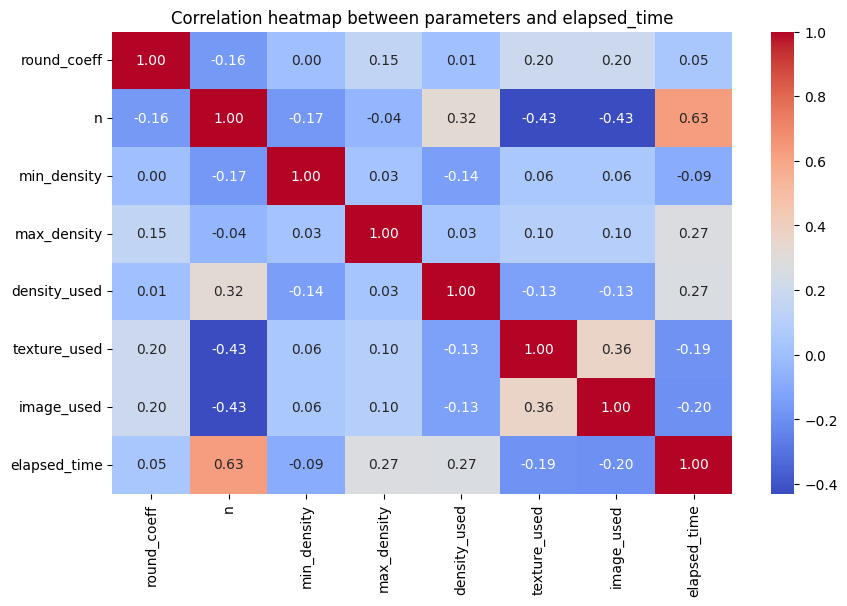


Importance of parameters:
n              0.555029
round_coeff    0.190123
max_density    0.189311
min_density    0.065537
dtype: float64


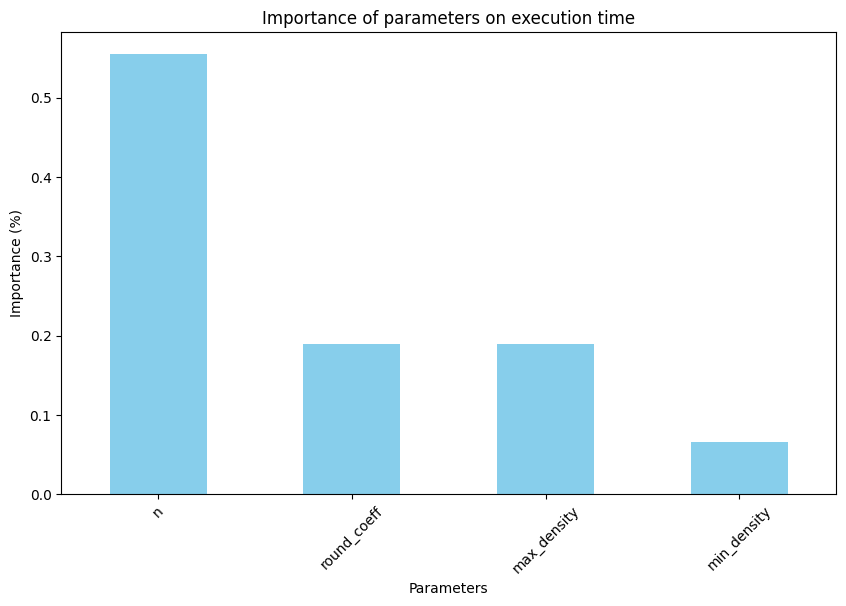

 94%|=================== | 1685/1787 [00:17<00:01]       

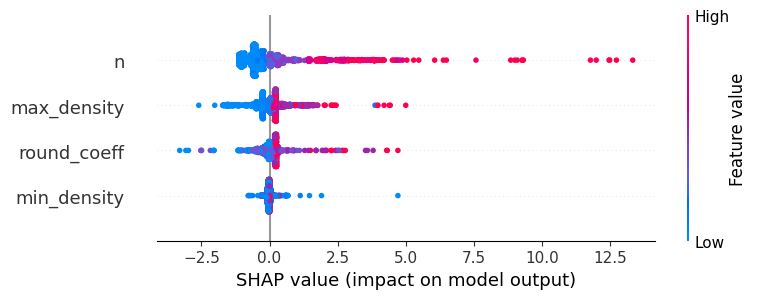

     Parameter       VIF
1            n  1.263272
2  min_density  1.375947
0  round_coeff  1.741791
3  max_density  1.873972

R² score with interactions: 0.779


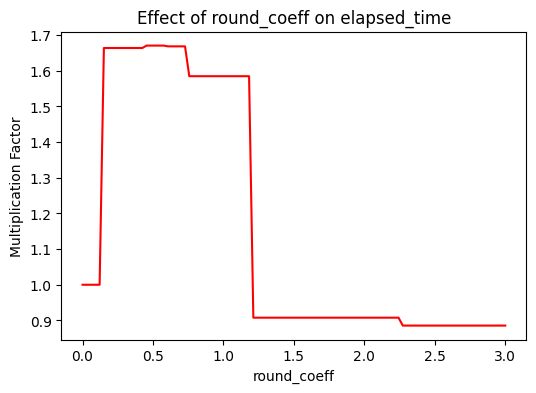

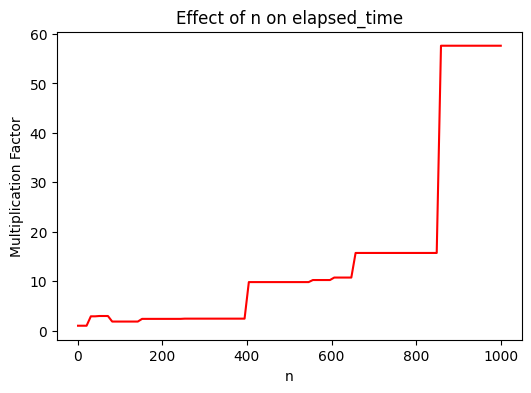

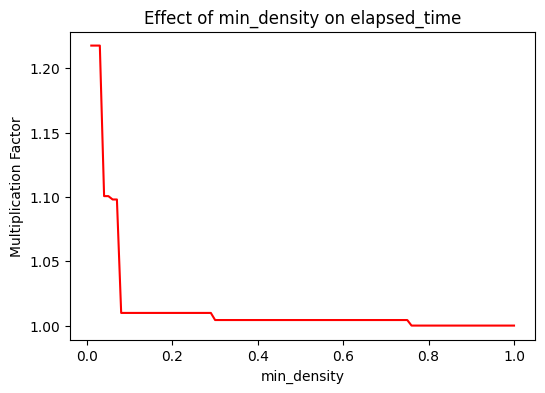

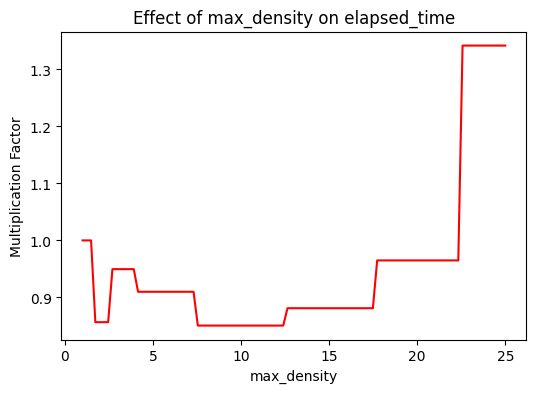

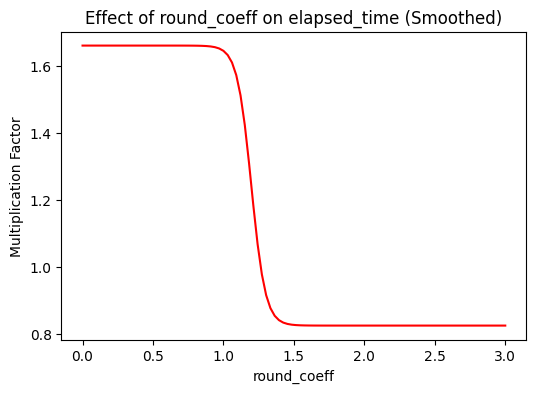

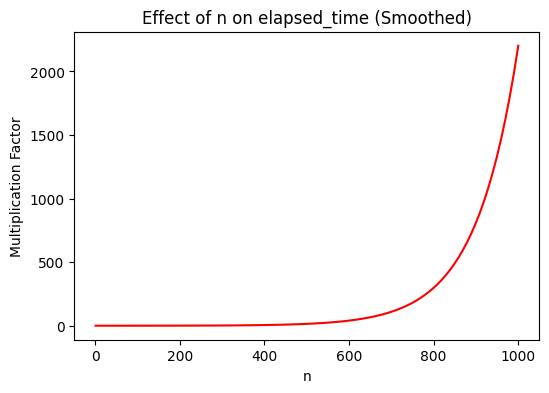

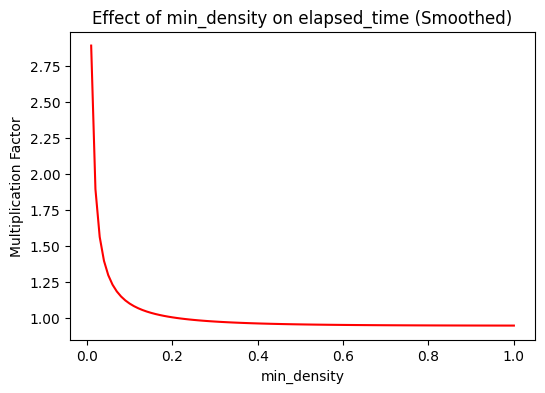

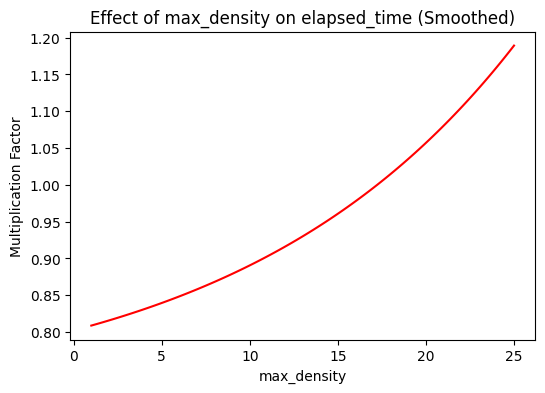

In [33]:
neutral_values = {
    "min_density": 1.0,
    "max_density": 1.0,
    "n": 1,
    "round_coeff": 0.0
}

df = load_data(BENCHMARK_CLEANED)
compute_correlation(df)
X, y, model = generate_model(df)
compute_importance(X, model)
compute_shap(X, model)
compute_vif(X)
compute_R2(X, y)

compute_factors(X, model, neutral_values, smoothing=False)
compute_factors(X, model, neutral_values)

### Benchmark Conclusion

After some adjustments and filtering, we end up with `n` (56%), `round_coeff` (19%), and `max_density` (19%) as the most impactful parameters on execution time, followed by `min_density` (7%).
Keep in mind that our dataset is relatively small, so these results may not be highly precise.